In [1]:
from collections import OrderedDict
from PIL import Image

import numpy as np
import matplotlib.pyplot as plt
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F

from torchvision import datasets, transforms

In [2]:
def view_classify(img, ps):
    
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

In [3]:
# Define a transform to normalize the data (Preprocessing)
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5), (0.5)) ])

# Download and load the training data
trainset    = datasets.MNIST('MNIST_data/', download=True, train=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32, shuffle=True)

# Download and load the test data
testset    = datasets.MNIST('MNIST_data/', download=True, train=False, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=32, shuffle=True)


In [6]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

model = Net()

In [7]:
optimizer = optim.Adam(model.parameters(), lr=0.003)
criterion = nn.CrossEntropyLoss()

training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
training...
trai

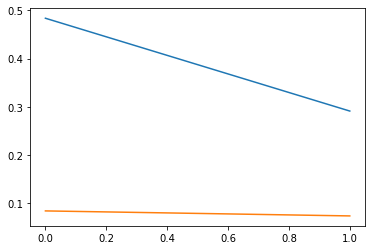

In [8]:
# Training loop

epochs = 2

train_losses = []
test_losses = []

for epoch in range(epochs):

    running_train_loss = 0
    running_test_loss = 0

    for train_imgs, train_labels in iter(trainloader):
        print('training...')

        optimizer.zero_grad()

        pred = model.forward(train_imgs)
        pred = pred.squeeze()
        # print(pred.shape, train_labels.shape)
        #train_labels = train_labels.float()
        train_labels = train_labels.long()

        train_loss = criterion(pred, train_labels)

        train_loss.backward()

        optimizer.step()

        running_train_loss += train_loss.item()

    model.eval()
    with torch.no_grad():

        for test_imgs, test_labels in iter(testloader):
            print('evaluating...')

            test_pred = model.forward(test_imgs)
            test_pred = test_pred.squeeze()

            #test_labels = test_labels.float()
            test_labels = test_labels.long()


            test_loss = criterion(test_pred, test_labels)

            running_test_loss += test_loss.item()
    model.train()
    
    avg_train_loss  = running_train_loss/len(trainloader)
    avg_test_loss   = running_test_loss/len(testloader)

    train_losses.append(avg_train_loss)
    test_losses.append(avg_test_loss)

    print(f'Epoch: {epoch+1} | train loss: {avg_train_loss} | test loss: {avg_test_loss}')


plt.plot(train_losses, label='train loss')
plt.plot(test_losses, label='test loss')

plt.show()


tensor([[1.0000e+00, 1.4194e-19, 2.9746e-10, 2.4670e-12, 2.1767e-16, 4.5810e-12,
         8.3997e-10, 4.2823e-08, 1.0929e-10, 2.2849e-08]],
       grad_fn=<SoftmaxBackward0>)


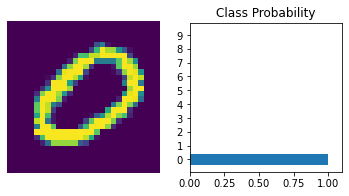

In [9]:
images, labels = next(iter(testloader))
#images.resize_(images.shape[0], 1, 784)
logit = model.forward(images[0,:])
ps = F.softmax(logit, dim =1)
print(ps)
view_classify(images[0].view(1, 28, 28), ps)


In [10]:
# saving model
#torch.save(model, './handrecgn_model.pt') 

### with my handwriting

In [11]:
trans = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5),(0.5))
    ])

tensor([[9.9312e-01, 1.9764e-07, 2.0962e-04, 4.4590e-07, 8.4727e-09, 1.0064e-03,
         2.2732e-03, 5.3784e-04, 2.8255e-03, 2.4497e-05]],
       grad_fn=<SoftmaxBackward0>)


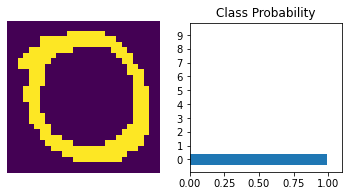

In [20]:
image = Image.open('nums_al/zero.png')
image = trans(image)
#image.resize_(image.shape[0], 1, 784)
image = torch.unsqueeze(image,1)
logit = model.forward(image[0,:])
ps = F.softmax(logit, dim =1)
print(ps)
view_classify(image[0].view(1, 28, 28), ps)